#**Binary classification with hipe4ml**

The goal of this tutorial is to provide an example of binary classification with machine learing techniques using the package [hipe4ml](https://hipe4ml.github.io/).

This tutorial is based on the measurement of the invariant mass of the $\mathrm{D^{+}}$ meson, through its three-body decay channel $\mathrm{D^{+}} \rightarrow \mathrm{K^{-}} + \pi^+ + \pi^+$, in the transverese-momentum interval $2 \leq p_{\mathrm{T}} < 3$ GeV/$c$. The data were collected by ALICE in 2010 and correspond to 240 million minimum-bias pp collisions at $\sqrt{s}$ = 7 TeV. In this data sample about 4.7 million $\mathrm{D^{+}}$ candidates have been reconstructed. For training and testing the algorithm, a Monte Carlo simulated data sample with about 4 thousand true $\mathrm{D^{+}}$ mesons is used.

All the data and the MC samples can be found at:

- data: https://cernbox.cern.ch/index.php/s/PBtQEyBt9zFJ9Fx
- MC (prompt): https://cernbox.cern.ch/index.php/s/98tSXndX0VhUMbi
- MC (feed-down): https://cernbox.cern.ch/index.php/s/R7j9zL7EBHA0v93

###**Prerequisites**

The following packages are needed to follow this tutorial and in general to use _hype4ml_:

- [_uproot_](https://github.com/scikit-hep/uproot) is a reader and a writer of the ROOT file data format and is used to cast blocks of data from the ROOT file as Numpy arrays.

- _xxhash_ and _lz4_ are used to decompress the files ufter download.


In [0]:
%%capture
!pip install hipe4ml
!pip install uproot
!pip install xxhash
!pip install lz4

###**File download**

All the files are downloaded from the repository.

In [0]:
%%capture
!curl -L https://cernbox.cern.ch/index.php/s/PBtQEyBt9zFJ9Fx/download --output data.root
!curl -L https://cernbox.cern.ch/index.php/s/98tSXndX0VhUMbi/download --output prompt.root
!curl -L https://cernbox.cern.ch/index.php/s/R7j9zL7EBHA0v93/download --output feeddown.root

###**Required python packages**

The packages required for the tutorial are imported in the following.

In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import uproot
from sklearn.model_selection import train_test_split
from hipe4ml.model_handler import ModelHandler
from hipe4ml import plot_utils

###**Preparing the training set and the test set**

All the sets are in _ROOT TTree_ data format and are converted to _pandas dataframe_ format.

The _signal_ set is taken from the MC sample and the _background_ set is taken from the data sample, selecting candidates with an invariant mass outside the expected signal region. The mass of $\mathrm{D^+}$ is 1.87 GeV/$c$: only the candidates with an inavariant mass $m < 1.82$ GeV/$c$ or $1.92< m < 2.0$ GeV/$c$ are selected. The region $m > 2$ GeV/$c$ is excluded to avoid possible contaminations from $\mathrm{D^{*+}}(2010)$. \\

Only a fraction of the whole data sample (in this example, 3 times the size of the signal set) is used to build the background set. By defalut, the method [_pandas.DataFrame.sample_](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) returns a random sample of candidats from the original set.



In [0]:
tree_prompt = uproot.open('prompt.root')['treeMLDplus']
df_prompt = tree_prompt.pandas.df()

# tree_feeddown = uproot.open('feeddown.root')['treeMLDplus']
# df_feeddown = tree_feeddown.pandas.df()

tree_data = uproot.open('data.root')['treeMLDplus']
df_data = tree_data.pandas.df()
df_bkg = df_data.query('inv_mass < 1.82 or 1.92 < inv_mass < 2.00')
df_bkg = df_bkg.sample(frac=len(df_prompt)/len(df_bkg)*3)

A _total set_ is built by merging the signal and the backgournd sets, the latter after the former. A label is assigned to each candidate of the total set, 0 for background and 1 for signal. The total set is split into a _train set_ and a _test set_, used for training and testing the algorithm, respectively. The fraction of the total set used as test set is defined by the _test_size_ parameter of the function [_sklearn.model_selection.train_test_split_](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [0]:
df_tot_train_test = pd.concat([df_bkg, df_prompt], sort=True)
labels_train_test = np.array([0]*len(df_bkg) + [1]*len(df_prompt))

train_set, test_set, y_train, y_test = train_test_split(df_tot_train_test, labels_train_test, test_size=0.5, random_state=42)


The distributions of the features for signal and background can be plotted using the function _plot\_utils_._plot\_distr_ of _hipe4ml_. Similarly, the correlation matrix for the features is plotted with the function _plt\_utils_._plot\_corr_.

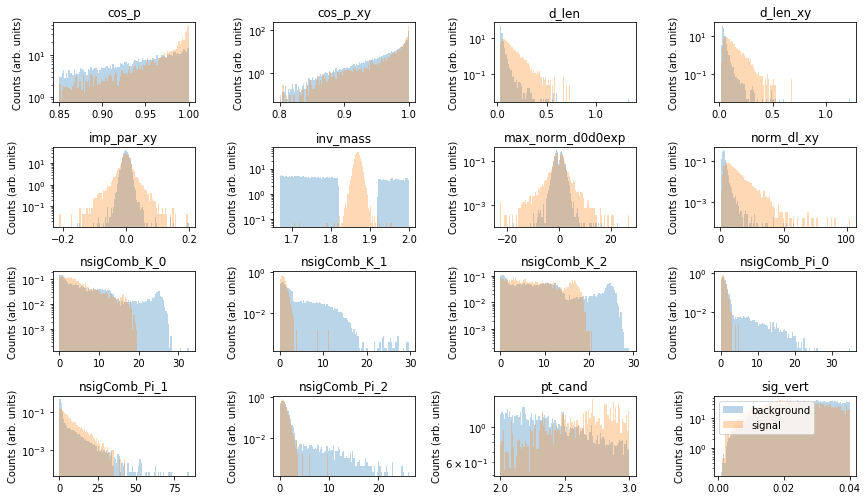

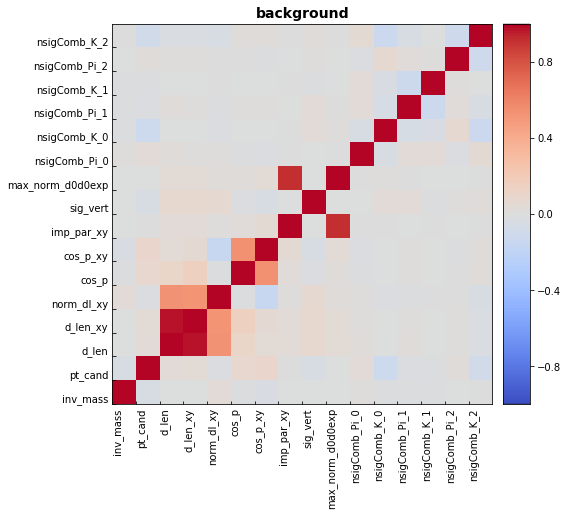

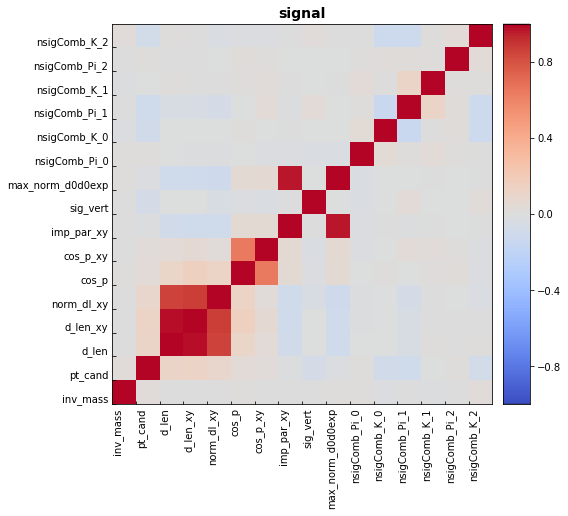

In [7]:
vars_to_draw = list(df_prompt.columns)

leg_labels = ['background', 'signal']

plot_utils.plot_distr([df_bkg, df_prompt], vars_to_draw, (12, 7), 100, True, leg_labels, 0.3)
plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
plot_utils.plot_corr([df_bkg, df_prompt], vars_to_draw, leg_labels)

plt.show()

Since we are interested in the measurement of the invariant mass distribution as a function of transverse momentum, both these features are not considered during the training process. Normally, it is also important to remove all the feature that are correlated with those of interest, but in this case there are no features singificantly correlated with the invarriant mass or with the transverse momentum.

In [0]:
features_for_train = vars_to_draw.copy()
features_for_train.remove('inv_mass')
features_for_train.remove('pt_cand')

###**The model**

For this example, [_XGBoost_](https://xgboost.readthedocs.io/en/latest/) is used as classification algorithm. XGBoost is an implementation of gradient boosted decision trees, designed to be highly efficient, flexible and portable.

The _hipe4ml_ package deals with the model through the _ModelHandler_ module. The model-handler is used to define the features used in the training process and to set the _hyperparameters_ of the model, such as the number of estimators, the maximum depth of the trees and the learning rate.



In [0]:
model_clf = xgb.XGBClassifier()
model_hdl = ModelHandler(model_clf, features_for_train)

###**Bayesian optimisation of hyperparameters**
The optimisation of the hyperparametes is a key step to obatine the best performace from the algorithm. In _hipe4ml_ a Bayesian optimisation is used throught the method _ModelHandler.optimize\_params\_bayes_.

It is an iterative procedure that scan the hyperparameter space in order to find the set of hyperparamiters that maximises the performances of the algorithm. The difference between other approaches, like _grid search_ or _random search_, and the Bayesian optimisation is that the latter takes into account past evaluations when choosing the hyperparameter set to evaluate next. This approach reduces the time necessary to find the optimal set of hyperparameters.

A set of hyperparameters should be tested on different samples to avoid overfitting problems. Since the number of events is limited, an approach called _cross validation_ is used. It has been proved that the cross validation removes the dependence of the model on the data sample. 

In the cross validation procedure, the original sample is divided in _n_ parts called _folds_ (in this case 5 folds are used). For each set of hyperparameters, _n-1_ folds are used for the optimisation and the remaining one as test. This operation is repeated after permuting the folds used for optimisation and for testing and the final result is the mean value of all the permutations.

The ModelHandler automatically updates the hyperparemeters after their optimisation.



In [12]:
train_test_data = [train_set, y_train, test_set, y_test]
hyper_pars_ranges = {'n_estimators': (200, 1000), 'max_depth': (2, 4), 'learning_rate': (0.01, 0.1)}
model_hdl.optimize_params_bayes(train_test_data, hyper_pars_ranges, 'roc_auc', nfold=5, init_points=5, n_iter=5, njobs=-1)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.9799   |  0.04371  |  3.901    |  785.6    |
|  2        |  0.9802   |  0.06388  |  2.312    |  324.8    |
|  3        |  0.9803   |  0.01523  |  3.732    |  680.9    |
|  4        |  0.9803   |  0.07373  |  2.041    |  975.9    |
|  5        |  0.9806   |  0.08492  |  2.425    |  345.5    |
|  6        |  0.9768   |  0.02151  |  3.531    |  200.0    |
|  7        |  0.9803   |  0.07067  |  2.228    |  999.9    |
|  8        |  0.9792   |  0.03953  |  2.294    |  345.5    |
|  9        |  0.9808   |  0.03975  |  2.415    |  999.7    |
|  10       |  0.9785   |  0.09503  |  3.148    |  999.9    |

Best target: 0.980778
Best parameters: {'n_estimators': 999.6735824688058, 'max_depth': 2.414876094210677, 'learning_rate': 0.039753277436542604}


###**Training and testing the model**
The model training is performed with the method _ModelHandler._train\_test\_model_. It requires as argument a list containing:
1. the training set;
2. the real class label for the training set;
3. the test set;
4. the real class label for the test set.

In [13]:
model_hdl.train_test_model(train_test_data)

Number of detected classes: 2
Training the final model: Done!
Testing the model: Done!
ROC_AUC_score: 0.982369


The predictions for the training and the test sets are obtained with the _predict_ method of the _ModelHandler_ module.

In [0]:
y_pred_train = model_hdl.predict(train_test_data[0], False)
y_pred_test = model_hdl.predict(train_test_data[2], False)

The results of the training process can be observed by plotting the distributions of the BDT score for the training and the test sets. This operation is performed with the method _plot\_utils_._plot\_output\_train\_test_.

The distributions of the model scores obtained from the test set are in good agreement with those obtained from the training set. This is a sign that tha model has been treined properly.

A disagreement between the distributions obtained from the training set and the datasets would reflect an overfitting by the classification algorithm: the classifier has learnt some characteristics that are peculiar of the training set but that are not true for a general sample.

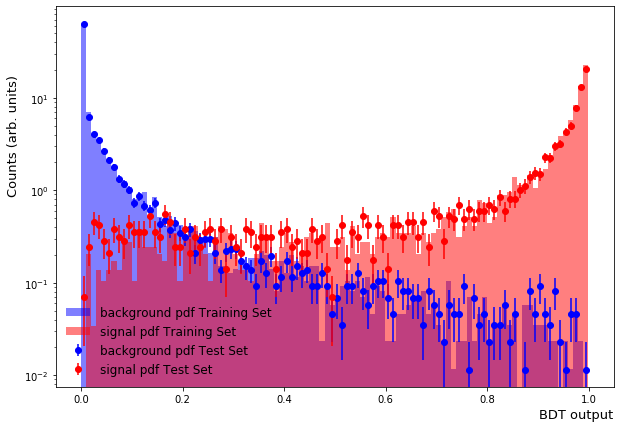

In [15]:
plt.rcParams["figure.figsize"] = (10, 7)

ml_out_fig = plot_utils.plot_output_train_test(model_hdl, train_test_data, 100, 
                                               False, leg_labels, True, density=True)

The quality of the algorithm can be also studied with the ROC curve, that can be plotted with the method _plot\_utils_._plot\_roc\_train\_test_. A good model classifier is characterised by a large area under the ROC curve (_ROC AUC_).

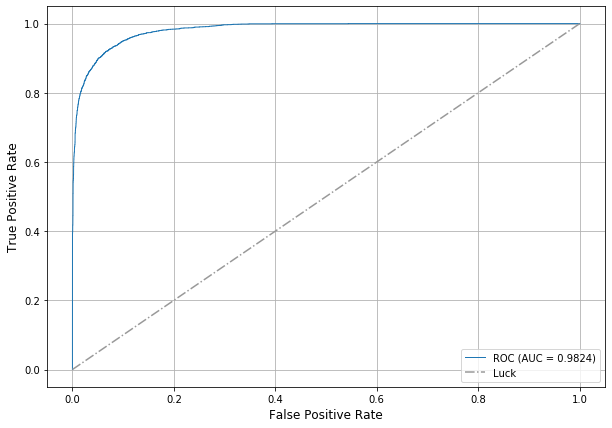

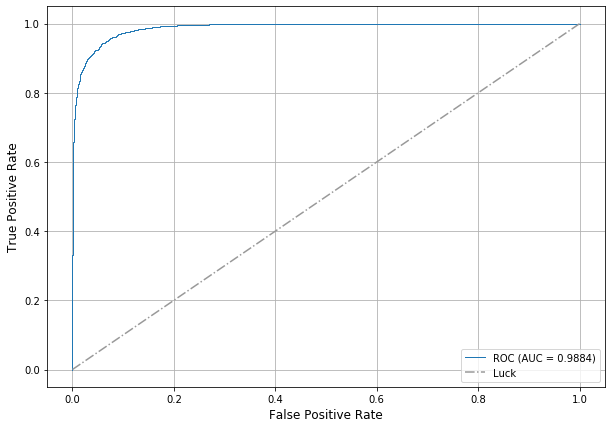

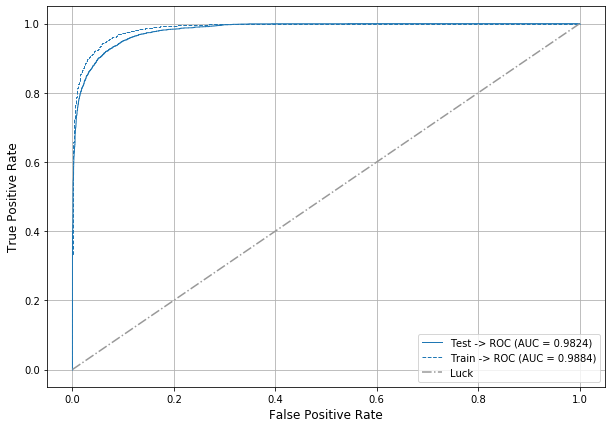

In [16]:
roc_train_test_fig = plot_utils.plot_roc_train_test(train_test_data[3], y_pred_test,
                                                    train_test_data[1], y_pred_train, None, leg_labels)

###**Apply the model to the data**

Once the model has been properly trained, it can be applied to data to separate signal from background events.

In [0]:
y_pred_data = model_hdl.predict(df_data, False)

The result of the model application to a data entry is a BDT score. Data can be selected according to theire BDT score: if tt is above a threshold value, the event is accepted.

In [0]:
df_data['BDT_output'] = y_pred_data
df_data_sel = df_data.query('BDT_output > 0.90')

After the application of the model to the data and the consequent selection on the output score, a clear signal is seen, while without any selection it is hidden by the background.

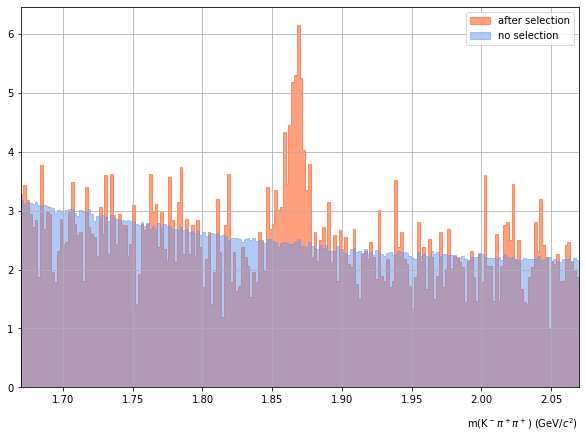

In [19]:
ax = plt.gca()
ax.set_xlabel(r'm(K$^-\pi^+\pi^+$) (GeV/$c^2$)')
ax.margins(x=0)
ax.xaxis.set_label_coords(0.9, -0.075)
df_data_sel.hist(column='inv_mass', bins=200, histtype='step', density=True, label='after selection', alpha=0.5, ax=ax, fill=True, color='orangered')
df_data.hist(column='inv_mass', bins=200, histtype='step', density=True, label='no selection', alpha=0.5, ax=ax, fill=True, color='cornflowerblue')
ax.set_title('')
ax.legend()
